In [1]:
%config IPCompleter.greedy=True

In [30]:
#!/usr/bin/env python

import tensorflow as tf
tf.__version__

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import PIL
import time
import datetime
from IPython import display

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose as C2DT
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing import image

#TODO:

# Try dataset with colors (CIFAR10 almost done)
# Try dataset with higher resolution
# Create a dataset with only one category (shoes?)
# Create more samples (Flip, rotate, skew..)


# NOTES:
# Might want to use Keras own image preprocessing functions
# when taking in a whole directory of images in png format.
# see https://keras.io/api/preprocessing/image/.

# Grade system (loosely based on Goodwins feedback)
# C - Color and medium resolution, with a filled in report (Master template with some text on each chapter)
# B - High resolution, and proof of concept for further research (place new clothes on models)
# A - Innovative


# GPU workaround
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


### CONFIG ###
EPOCHS = 50
NOISE_DIM = 100
NUM_EXAMPLES = 16

BUFFER_SIZE = 40000
BATCH_SIZE = 128

DATA_PATH = "data"
IMAGE_PATH = "imgs"
MODELS_PATH = "models"


### INIT ###
seed = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])
now = datetime.datetime.now().strftime("%d%H%M%S")
folder = os.path.join(IMAGE_PATH, now)
MODELS_FOLDER = os.path.join(MODELS_PATH, now)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Make sure folders exists
if not os.path.exists(MODELS_PATH):
    os.mkdir(MODELS_PATH)
if not os.path.exists(MODELS_FOLDER):
    os.mkdir(MODELS_FOLDER)
if not os.path.exists(folder):
    os.mkdir(folder)
if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)
if not os.path.exists(IMAGE_PATH):
    os.mkdir(IMAGE_PATH)    

def get_dataset():
    shoes_path = "data/fashion-shoes-28"
    shoes = os.listdir(shoes_path)
    images = []
    for k in shoes:
        if k.startswith("."):
            continue
        img_path = os.path.join(shoes_path, k)
        
        img = image.load_img(img_path, target_size=(28,28,1), color_mode="grayscale")
        img = image.img_to_array(img)
#         img = img/-255 #invert grayscale
        images.append(img)

    images = np.asarray(images)
    
    print("Number of images:", images.shape)
    train_images = images.reshape(images.shape[0], 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
    dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    return dataset

def plot_image(size):
    
    shoes_path = "data/fashion-shoes-"+str(size)
    shoes = os.listdir(shoes_path)
   
    img_path = os.path.join(shoes_path, shoes[2])

    img = image.load_img(img_path, target_size=(size,size,1), color_mode="grayscale")
    img = image.img_to_array(img)
    img = img/-255 #invert grayscale
    
    img = img.reshape(size,size)
    plt.imshow(img, cmap="Greys")

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((7, 7, 256)))
    model.add(C2DT(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(C2DT(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(C2DT(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1))
    return model


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = (real_loss * 0.9) + fake_loss
    print("total:", total_loss)
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    G_optimizer.apply_gradients(zip(gradients_of_generator, 
        generator.trainable_variables))
    D_optimizer.apply_gradients(zip(gradients_of_discriminator, 
        discriminator.trainable_variables))


def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


def train_forever(dataset):
    epoch = 0
    try:
        while(True):
            start = time.time()

            for image_batch in dataset:
                train_step(image_batch)
        
            
            if (epoch + 1) % 10 == 0:
                checkpoint.save(file_prefix = checkpoint_prefix)

                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch + 1, seed)

            print ('Time for epoch {} is {:.4f} sec'.format(epoch + 1, time.time()-start))
            epoch += 1
    except KeyboardInterrupt:
        print("KeyboardInterrupt. Stopping training.")
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 2, seed)


def generate_and_save_images(model, epoch, seed):
    predictions = model(seed, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('{}/image_at_epoch_{:05d}.png'.format(folder, epoch))
    plt.close(fig)

    # Save generator model
    filename = '{}/generator_model_{:05d}.h5'.format(MODELS_FOLDER, epoch)
    model.save(filename)


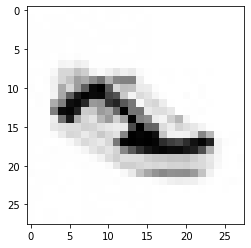

In [29]:
plot_image(28)

In [31]:
if __name__ == '__main__':

    train_dataset   = get_dataset()
    generator       = make_generator_model()
    discriminator   = make_discriminator_model()

    cross_entropy = BinaryCrossentropy(from_logits=True)

    # learningrate started at 1e-4
    G_optimizer = Adam(0.00001)
    D_optimizer = Adam(0.00004)

    checkpoint = tf.train.Checkpoint(generator_otimizer=G_optimizer,
                                    discriminator_optimizer=D_optimizer,
                                    generator=generator, discriminator=discriminator)

    #train(train_dataset, EPOCHS)
    train_forever(train_dataset)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Time for epoch 2070 is 0.9805 sec
Time for epoch 2071 is 0.7800 sec
Time for epoch 2072 is 0.7811 sec
Time for epoch 2073 is 0.7831 sec
KeyboardInterrupt. Stopping training.
